In [1]:
%load_ext autoreload 
%autoreload 2

# Exp2 Modify DCGAN to generate 128*128 images

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2

In [3]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 50
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# dataloader
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
criterion = nn.BCELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [10,25], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [10,25], gamma=0.1)

202599
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [5]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp2/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [6]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/50] Iter:1  Loss_D=1.8912 Loss_G=10.6085 D(x)=0.5136 D(G(z))=0.5371, 0.0000
[0/50] Iter:51  Loss_D=8.0391 Loss_G=45.1748 D(x)=0.9715 D(G(z))=0.0000, 0.0000
[0/50] Iter:101  Loss_D=6.2522 Loss_G=40.4154 D(x)=0.9817 D(G(z))=0.0000, 0.0000
[0/50] Iter:151  Loss_D=6.3591 Loss_G=38.6144 D(x)=0.9367 D(G(z))=0.0000, 0.0000
[0/50] Iter:201  Loss_D=7.5001 Loss_G=43.4334 D(x)=0.9646 D(G(z))=0.0000, 0.0000
[0/50] Iter:251  Loss_D=0.9727 Loss_G=1.1991 D(x)=0.7957 D(G(z))=0.2096, 0.2897
[0/50] Iter:301  Loss_D=0.7387 Loss_G=2.4704 D(x)=0.9214 D(G(z))=0.2642, 0.0921
[0/50] Iter:351  Loss_D=1.1613 Loss_G=1.0168 D(x)=0.6858 D(G(z))=0.5085, 0.3707
[0/50] Iter:401  Loss_D=1.0253 Loss_G=1.3177 D(x)=0.7670 D(G(z))=0.4716, 0.2784
[0/50] Iter:451  Loss_D=1.1172 Loss_G=0.7159 D(x)=0.6146 D(G(z))=0.3630, 0.5016
[0/50] Iter:501  Loss_D=0.9393 Loss_G=1.3337 D(x)=0.7038 D(G(z))=0.3045, 0.2588
[0/50] Iter:551  Loss_D=0.9831 Loss_G=1.3651 D(x)=0.7122 D(G(z))=0.3148, 0.2647
[0/50] Iter:601  Loss_D=1.7112 Loss_G=

[3/50] Iter:351  Loss_D=1.6651 Loss_G=1.3010 D(x)=0.7656 D(G(z))=0.7373, 0.2806
[3/50] Iter:401  Loss_D=1.0840 Loss_G=1.1976 D(x)=0.7149 D(G(z))=0.4453, 0.3105
[3/50] Iter:451  Loss_D=1.6482 Loss_G=1.7623 D(x)=0.7913 D(G(z))=0.7669, 0.1655
[3/50] Iter:501  Loss_D=1.5461 Loss_G=0.5429 D(x)=0.3337 D(G(z))=0.1464, 0.6229
[3/50] Iter:551  Loss_D=1.0524 Loss_G=1.2716 D(x)=0.7376 D(G(z))=0.4518, 0.2867
[3/50] Iter:601  Loss_D=1.7846 Loss_G=0.5470 D(x)=0.3541 D(G(z))=0.4836, 0.6012
[3/50] Iter:651  Loss_D=1.3473 Loss_G=2.2854 D(x)=0.8792 D(G(z))=0.6968, 0.1028
[3/50] Iter:701  Loss_D=1.4220 Loss_G=0.7592 D(x)=0.4064 D(G(z))=0.2789, 0.4798
[3/50] Iter:751  Loss_D=2.0352 Loss_G=0.4030 D(x)=0.5626 D(G(z))=0.3128, 0.7258
[3/50] Iter:801  Loss_D=0.9885 Loss_G=1.2927 D(x)=0.6491 D(G(z))=0.2895, 0.2840
[3/50] Iter:851  Loss_D=0.9917 Loss_G=1.3074 D(x)=0.7045 D(G(z))=0.3748, 0.2760
[3/50] Iter:901  Loss_D=1.0731 Loss_G=1.0510 D(x)=0.6491 D(G(z))=0.4043, 0.3484
[3/50] Iter:951  Loss_D=1.3757 Loss_G=1.

[6/50] Iter:701  Loss_D=0.9206 Loss_G=1.7624 D(x)=0.8111 D(G(z))=0.4253, 0.1702
[6/50] Iter:751  Loss_D=0.9427 Loss_G=2.2113 D(x)=0.8722 D(G(z))=0.4842, 0.1115
[6/50] Iter:801  Loss_D=0.8542 Loss_G=1.6445 D(x)=0.7815 D(G(z))=0.3086, 0.2008
[6/50] Iter:851  Loss_D=1.3055 Loss_G=1.9868 D(x)=0.8056 D(G(z))=0.6253, 0.1407
[6/50] Iter:901  Loss_D=0.8535 Loss_G=2.5920 D(x)=0.8865 D(G(z))=0.4363, 0.0703
[6/50] Iter:951  Loss_D=0.8535 Loss_G=1.5603 D(x)=0.7715 D(G(z))=0.2561, 0.2202
[6/50] Iter:1001  Loss_D=1.7090 Loss_G=0.6954 D(x)=0.3119 D(G(z))=0.0537, 0.5361
[6/50] Iter:1051  Loss_D=1.1259 Loss_G=2.9685 D(x)=0.8941 D(G(z))=0.6002, 0.0509
[6/50] Iter:1101  Loss_D=1.0443 Loss_G=1.3421 D(x)=0.7465 D(G(z))=0.4687, 0.2728
[6/50] Iter:1151  Loss_D=1.2176 Loss_G=1.9081 D(x)=0.6937 D(G(z))=0.5364, 0.1617
[6/50] Iter:1201  Loss_D=1.4851 Loss_G=0.7742 D(x)=0.3825 D(G(z))=0.0585, 0.4765
[6/50] Iter:1251  Loss_D=0.8861 Loss_G=1.2244 D(x)=0.7562 D(G(z))=0.3391, 0.3102
[6/50] Iter:1301  Loss_D=1.0889 Lo

[9/50] Iter:1051  Loss_D=0.7795 Loss_G=1.5048 D(x)=0.7935 D(G(z))=0.1865, 0.2262
[9/50] Iter:1101  Loss_D=0.8766 Loss_G=1.1587 D(x)=0.6983 D(G(z))=0.1666, 0.3239
[9/50] Iter:1151  Loss_D=1.5460 Loss_G=0.7325 D(x)=0.3318 D(G(z))=0.1253, 0.4942
[9/50] Iter:1201  Loss_D=0.9493 Loss_G=2.4656 D(x)=0.9415 D(G(z))=0.5210, 0.0821
[9/50] Iter:1251  Loss_D=1.1684 Loss_G=3.0751 D(x)=0.9462 D(G(z))=0.5787, 0.0406
[9/50] Iter:1301  Loss_D=0.8511 Loss_G=1.5202 D(x)=0.7693 D(G(z))=0.3405, 0.2215
[9/50] Iter:1351  Loss_D=1.6041 Loss_G=1.1456 D(x)=0.7270 D(G(z))=0.7325, 0.3267
[9/50] Iter:1401  Loss_D=0.8415 Loss_G=2.0910 D(x)=0.8500 D(G(z))=0.3459, 0.1231
[9/50] Iter:1451  Loss_D=1.3993 Loss_G=0.9004 D(x)=0.4999 D(G(z))=0.4191, 0.4457
[9/50] Iter:1501  Loss_D=1.4388 Loss_G=0.9067 D(x)=0.3783 D(G(z))=0.1010, 0.4212
[9/50] Iter:1551  Loss_D=0.7939 Loss_G=1.1383 D(x)=0.7494 D(G(z))=0.2035, 0.3282
[10/50] Iter:1  Loss_D=1.3472 Loss_G=0.5807 D(x)=0.9673 D(G(z))=0.7144, 0.5852
[10/50] Iter:51  Loss_D=0.7522

[12/50] Iter:1301  Loss_D=0.7526 Loss_G=1.8476 D(x)=0.8414 D(G(z))=0.1907, 0.1617
[12/50] Iter:1351  Loss_D=0.7479 Loss_G=1.3428 D(x)=0.8088 D(G(z))=0.2589, 0.2614
[12/50] Iter:1401  Loss_D=0.6941 Loss_G=1.4942 D(x)=0.8498 D(G(z))=0.2415, 0.2183
[12/50] Iter:1451  Loss_D=0.7758 Loss_G=1.2834 D(x)=0.8775 D(G(z))=0.3376, 0.2735
[12/50] Iter:1501  Loss_D=0.7017 Loss_G=1.5922 D(x)=0.8353 D(G(z))=0.1363, 0.1964
[12/50] Iter:1551  Loss_D=2.7916 Loss_G=1.0465 D(x)=0.8271 D(G(z))=0.3153, 0.3522
[13/50] Iter:1  Loss_D=0.6489 Loss_G=1.4901 D(x)=0.8775 D(G(z))=0.2179, 0.2245
[13/50] Iter:51  Loss_D=0.6455 Loss_G=1.5964 D(x)=0.9006 D(G(z))=0.1761, 0.2057
[13/50] Iter:101  Loss_D=0.7735 Loss_G=1.7253 D(x)=0.9077 D(G(z))=0.2693, 0.1722
[13/50] Iter:151  Loss_D=0.7431 Loss_G=1.3977 D(x)=0.8046 D(G(z))=0.2609, 0.2441
[13/50] Iter:201  Loss_D=0.8347 Loss_G=1.1984 D(x)=0.7858 D(G(z))=0.3469, 0.3108
[13/50] Iter:251  Loss_D=0.7904 Loss_G=1.1646 D(x)=0.7874 D(G(z))=0.3121, 0.3108
[13/50] Iter:301  Loss_D=

[15/50] Iter:1551  Loss_D=0.7389 Loss_G=1.5013 D(x)=0.8533 D(G(z))=0.2405, 0.2224
[16/50] Iter:1  Loss_D=0.6919 Loss_G=1.7304 D(x)=0.8380 D(G(z))=0.1532, 0.1775
[16/50] Iter:51  Loss_D=0.6398 Loss_G=1.5550 D(x)=0.8744 D(G(z))=0.2272, 0.2195
[16/50] Iter:101  Loss_D=0.6656 Loss_G=1.5262 D(x)=0.8522 D(G(z))=0.1771, 0.2157
[16/50] Iter:151  Loss_D=0.7862 Loss_G=1.2584 D(x)=0.8169 D(G(z))=0.2679, 0.2927
[16/50] Iter:201  Loss_D=0.6936 Loss_G=1.7116 D(x)=0.8681 D(G(z))=0.1742, 0.1741
[16/50] Iter:251  Loss_D=0.8285 Loss_G=1.3326 D(x)=0.8557 D(G(z))=0.3254, 0.2659
[16/50] Iter:301  Loss_D=0.6314 Loss_G=1.7330 D(x)=0.9099 D(G(z))=0.2369, 0.1809
[16/50] Iter:351  Loss_D=0.6511 Loss_G=1.6711 D(x)=0.9040 D(G(z))=0.1854, 0.1908
[16/50] Iter:401  Loss_D=0.6933 Loss_G=1.5427 D(x)=0.9028 D(G(z))=0.2059, 0.2143
[16/50] Iter:451  Loss_D=0.7601 Loss_G=1.5437 D(x)=0.8507 D(G(z))=0.2106, 0.2171
[16/50] Iter:501  Loss_D=3.0564 Loss_G=1.1596 D(x)=0.7931 D(G(z))=0.2124, 0.3174
[16/50] Iter:551  Loss_D=0.686

[19/50] Iter:201  Loss_D=2.8494 Loss_G=0.9943 D(x)=0.7897 D(G(z))=0.2510, 0.3770
[19/50] Iter:251  Loss_D=0.6619 Loss_G=1.6071 D(x)=0.8961 D(G(z))=0.2624, 0.2009
[19/50] Iter:301  Loss_D=0.6185 Loss_G=1.7677 D(x)=0.8980 D(G(z))=0.1490, 0.1702
[19/50] Iter:351  Loss_D=0.7749 Loss_G=1.4564 D(x)=0.7846 D(G(z))=0.1948, 0.2304
[19/50] Iter:401  Loss_D=0.7081 Loss_G=1.6352 D(x)=0.8934 D(G(z))=0.2399, 0.1990
[19/50] Iter:451  Loss_D=0.7128 Loss_G=1.5487 D(x)=0.8329 D(G(z))=0.1391, 0.2077
[19/50] Iter:501  Loss_D=0.6801 Loss_G=1.5054 D(x)=0.8751 D(G(z))=0.2826, 0.2323
[19/50] Iter:551  Loss_D=0.6799 Loss_G=1.4724 D(x)=0.8852 D(G(z))=0.1926, 0.2300
[19/50] Iter:601  Loss_D=0.6235 Loss_G=1.8366 D(x)=0.9151 D(G(z))=0.2009, 0.1588
[19/50] Iter:651  Loss_D=0.7489 Loss_G=1.5543 D(x)=0.8625 D(G(z))=0.3469, 0.2131
[19/50] Iter:701  Loss_D=0.7034 Loss_G=1.4781 D(x)=0.8496 D(G(z))=0.2543, 0.2222
[19/50] Iter:751  Loss_D=0.7019 Loss_G=1.4150 D(x)=0.8806 D(G(z))=0.2366, 0.2501
[19/50] Iter:801  Loss_D=0.6

[22/50] Iter:451  Loss_D=0.7439 Loss_G=1.5287 D(x)=0.8815 D(G(z))=0.2635, 0.2199
[22/50] Iter:501  Loss_D=0.6994 Loss_G=1.4045 D(x)=0.8440 D(G(z))=0.2174, 0.2404
[22/50] Iter:551  Loss_D=0.7184 Loss_G=1.6892 D(x)=0.8588 D(G(z))=0.2083, 0.1843
[22/50] Iter:601  Loss_D=0.7290 Loss_G=1.4985 D(x)=0.8282 D(G(z))=0.1773, 0.2215
[22/50] Iter:651  Loss_D=0.8045 Loss_G=1.1051 D(x)=0.7530 D(G(z))=0.2252, 0.3279
[22/50] Iter:701  Loss_D=0.8814 Loss_G=1.1384 D(x)=0.7229 D(G(z))=0.2935, 0.3191
[22/50] Iter:751  Loss_D=0.7325 Loss_G=1.5607 D(x)=0.8312 D(G(z))=0.2406, 0.2113
[22/50] Iter:801  Loss_D=0.7854 Loss_G=1.4832 D(x)=0.8834 D(G(z))=0.3503, 0.2240
[22/50] Iter:851  Loss_D=0.6570 Loss_G=1.6001 D(x)=0.8772 D(G(z))=0.1913, 0.1962
[22/50] Iter:901  Loss_D=0.7458 Loss_G=1.5451 D(x)=0.9358 D(G(z))=0.3029, 0.2072
[22/50] Iter:951  Loss_D=0.7870 Loss_G=1.5590 D(x)=0.8509 D(G(z))=0.3252, 0.2107
[22/50] Iter:1001  Loss_D=0.6266 Loss_G=1.5351 D(x)=0.9134 D(G(z))=0.2729, 0.2137
[22/50] Iter:1051  Loss_D=0

[25/50] Iter:701  Loss_D=0.6663 Loss_G=1.5263 D(x)=0.9057 D(G(z))=0.2323, 0.2297
[25/50] Iter:751  Loss_D=0.7492 Loss_G=1.3295 D(x)=0.8569 D(G(z))=0.2607, 0.2597
[25/50] Iter:801  Loss_D=0.7415 Loss_G=1.4928 D(x)=0.8431 D(G(z))=0.2153, 0.2187
[25/50] Iter:851  Loss_D=0.6649 Loss_G=1.6968 D(x)=0.8746 D(G(z))=0.1896, 0.1862
[25/50] Iter:901  Loss_D=0.7285 Loss_G=1.4358 D(x)=0.9191 D(G(z))=0.2561, 0.2399
[25/50] Iter:951  Loss_D=0.7026 Loss_G=1.3054 D(x)=0.9082 D(G(z))=0.2727, 0.2650
[25/50] Iter:1001  Loss_D=0.7285 Loss_G=1.4163 D(x)=0.8687 D(G(z))=0.2308, 0.2325
[25/50] Iter:1051  Loss_D=0.7658 Loss_G=1.3657 D(x)=0.8021 D(G(z))=0.2480, 0.2523
[25/50] Iter:1101  Loss_D=0.7469 Loss_G=1.3523 D(x)=0.8511 D(G(z))=0.2557, 0.2548
[25/50] Iter:1151  Loss_D=0.6403 Loss_G=1.5198 D(x)=0.9072 D(G(z))=0.2201, 0.2180
[25/50] Iter:1201  Loss_D=0.7016 Loss_G=1.4206 D(x)=0.8695 D(G(z))=0.2237, 0.2297
[25/50] Iter:1251  Loss_D=0.7406 Loss_G=1.5226 D(x)=0.9195 D(G(z))=0.2297, 0.2219
[25/50] Iter:1301  Los

[28/50] Iter:951  Loss_D=0.6710 Loss_G=1.6844 D(x)=0.8922 D(G(z))=0.1823, 0.1856
[28/50] Iter:1001  Loss_D=0.7103 Loss_G=1.3682 D(x)=0.8669 D(G(z))=0.2538, 0.2510
[28/50] Iter:1051  Loss_D=0.7801 Loss_G=1.5388 D(x)=0.8152 D(G(z))=0.2159, 0.2232
[28/50] Iter:1101  Loss_D=0.6418 Loss_G=1.5031 D(x)=0.8969 D(G(z))=0.2325, 0.2255
[28/50] Iter:1151  Loss_D=0.6914 Loss_G=1.4198 D(x)=0.8440 D(G(z))=0.2527, 0.2471
[28/50] Iter:1201  Loss_D=0.6841 Loss_G=1.5167 D(x)=0.8686 D(G(z))=0.2138, 0.2124
[28/50] Iter:1251  Loss_D=0.6496 Loss_G=1.5412 D(x)=0.8617 D(G(z))=0.2070, 0.2092
[28/50] Iter:1301  Loss_D=0.6197 Loss_G=1.5829 D(x)=0.9057 D(G(z))=0.2009, 0.2005
[28/50] Iter:1351  Loss_D=0.6957 Loss_G=1.4351 D(x)=0.8611 D(G(z))=0.2496, 0.2436
[28/50] Iter:1401  Loss_D=0.7372 Loss_G=1.5274 D(x)=0.8253 D(G(z))=0.2104, 0.2181
[28/50] Iter:1451  Loss_D=0.6496 Loss_G=1.5864 D(x)=0.8770 D(G(z))=0.2098, 0.2039
[28/50] Iter:1501  Loss_D=0.6845 Loss_G=1.4365 D(x)=0.8580 D(G(z))=0.2280, 0.2326
[28/50] Iter:1551

[31/50] Iter:1201  Loss_D=0.7147 Loss_G=1.3057 D(x)=0.8930 D(G(z))=0.2838, 0.2681
[31/50] Iter:1251  Loss_D=0.7339 Loss_G=1.5105 D(x)=0.8503 D(G(z))=0.2242, 0.2228
[31/50] Iter:1301  Loss_D=0.6306 Loss_G=1.4754 D(x)=0.9449 D(G(z))=0.2467, 0.2353
[31/50] Iter:1351  Loss_D=0.6614 Loss_G=1.5569 D(x)=0.8601 D(G(z))=0.2055, 0.2074
[31/50] Iter:1401  Loss_D=0.7038 Loss_G=1.4317 D(x)=0.9101 D(G(z))=0.2517, 0.2452
[31/50] Iter:1451  Loss_D=0.6941 Loss_G=1.5201 D(x)=0.8572 D(G(z))=0.2275, 0.2297
[31/50] Iter:1501  Loss_D=0.6621 Loss_G=1.5002 D(x)=0.8772 D(G(z))=0.2176, 0.2199
[31/50] Iter:1551  Loss_D=0.6575 Loss_G=1.4818 D(x)=0.8642 D(G(z))=0.2257, 0.2271
[32/50] Iter:1  Loss_D=0.6990 Loss_G=1.4586 D(x)=0.9207 D(G(z))=0.2444, 0.2342
[32/50] Iter:51  Loss_D=0.6971 Loss_G=1.5940 D(x)=0.8680 D(G(z))=0.2035, 0.2037
[32/50] Iter:101  Loss_D=0.6894 Loss_G=1.2961 D(x)=0.8678 D(G(z))=0.2742, 0.2727
[32/50] Iter:151  Loss_D=0.6425 Loss_G=1.4710 D(x)=0.8834 D(G(z))=0.2336, 0.2253
[32/50] Iter:201  Loss_

[34/50] Iter:1451  Loss_D=0.7071 Loss_G=1.4445 D(x)=0.8628 D(G(z))=0.2435, 0.2423
[34/50] Iter:1501  Loss_D=0.6364 Loss_G=1.5174 D(x)=0.8940 D(G(z))=0.2239, 0.2246
[34/50] Iter:1551  Loss_D=0.7623 Loss_G=1.3836 D(x)=0.8422 D(G(z))=0.2531, 0.2532
[35/50] Iter:1  Loss_D=0.6781 Loss_G=1.4078 D(x)=0.8699 D(G(z))=0.2489, 0.2458
[35/50] Iter:51  Loss_D=0.6427 Loss_G=1.6081 D(x)=0.8745 D(G(z))=0.1938, 0.2009
[35/50] Iter:101  Loss_D=0.7598 Loss_G=1.4527 D(x)=0.8264 D(G(z))=0.2270, 0.2335
[35/50] Iter:151  Loss_D=0.6686 Loss_G=1.5399 D(x)=0.8794 D(G(z))=0.2010, 0.2069
[35/50] Iter:201  Loss_D=0.6467 Loss_G=1.6529 D(x)=0.8597 D(G(z))=0.1835, 0.1923
[35/50] Iter:251  Loss_D=0.7267 Loss_G=1.5251 D(x)=0.9072 D(G(z))=0.2271, 0.2220
[35/50] Iter:301  Loss_D=0.6570 Loss_G=1.4415 D(x)=0.8957 D(G(z))=0.2419, 0.2368
[35/50] Iter:351  Loss_D=0.7892 Loss_G=1.4311 D(x)=0.8623 D(G(z))=0.2382, 0.2361
[35/50] Iter:401  Loss_D=0.6444 Loss_G=1.5312 D(x)=0.9135 D(G(z))=0.2204, 0.2159
[35/50] Iter:451  Loss_D=0.6

[38/50] Iter:101  Loss_D=3.5613 Loss_G=1.5206 D(x)=0.8862 D(G(z))=0.2183, 0.2231
[38/50] Iter:151  Loss_D=0.7752 Loss_G=1.4424 D(x)=0.8738 D(G(z))=0.2491, 0.2417
[38/50] Iter:201  Loss_D=0.7056 Loss_G=1.4235 D(x)=0.8923 D(G(z))=0.2428, 0.2393
[38/50] Iter:251  Loss_D=0.7037 Loss_G=1.3978 D(x)=0.9040 D(G(z))=0.2591, 0.2468
[38/50] Iter:301  Loss_D=0.6849 Loss_G=1.4083 D(x)=0.8769 D(G(z))=0.2611, 0.2470
[38/50] Iter:351  Loss_D=0.7406 Loss_G=1.2575 D(x)=0.9044 D(G(z))=0.2941, 0.2800
[38/50] Iter:401  Loss_D=0.6917 Loss_G=1.5832 D(x)=0.9054 D(G(z))=0.2117, 0.2104
[38/50] Iter:451  Loss_D=0.6496 Loss_G=1.5651 D(x)=0.8835 D(G(z))=0.2091, 0.2080
[38/50] Iter:501  Loss_D=0.6926 Loss_G=1.6403 D(x)=0.8850 D(G(z))=0.1830, 0.1869
[38/50] Iter:551  Loss_D=0.6487 Loss_G=1.8054 D(x)=0.9220 D(G(z))=0.1619, 0.1638
[38/50] Iter:601  Loss_D=0.7980 Loss_G=1.3516 D(x)=0.8072 D(G(z))=0.2465, 0.2495
[38/50] Iter:651  Loss_D=0.6764 Loss_G=1.5861 D(x)=0.8725 D(G(z))=0.1898, 0.1960
[38/50] Iter:701  Loss_D=0.6

[41/50] Iter:351  Loss_D=0.7850 Loss_G=1.2372 D(x)=0.8805 D(G(z))=0.3112, 0.2977
[41/50] Iter:401  Loss_D=0.7840 Loss_G=1.3553 D(x)=0.7852 D(G(z))=0.2637, 0.2613
[41/50] Iter:451  Loss_D=0.6611 Loss_G=1.5880 D(x)=0.8668 D(G(z))=0.1942, 0.2028
[41/50] Iter:501  Loss_D=0.7721 Loss_G=1.3949 D(x)=0.8012 D(G(z))=0.2473, 0.2475
[41/50] Iter:551  Loss_D=0.6732 Loss_G=1.5168 D(x)=0.8598 D(G(z))=0.2192, 0.2215
[41/50] Iter:601  Loss_D=0.7115 Loss_G=1.3802 D(x)=0.8211 D(G(z))=0.2508, 0.2485
[41/50] Iter:651  Loss_D=0.6981 Loss_G=1.3862 D(x)=0.8665 D(G(z))=0.2458, 0.2470
[41/50] Iter:701  Loss_D=0.7346 Loss_G=1.5291 D(x)=0.8437 D(G(z))=0.2156, 0.2142
[41/50] Iter:751  Loss_D=0.6967 Loss_G=1.5113 D(x)=0.9066 D(G(z))=0.2266, 0.2255
[41/50] Iter:801  Loss_D=0.7214 Loss_G=1.6078 D(x)=0.8413 D(G(z))=0.2000, 0.2028
[41/50] Iter:851  Loss_D=0.6802 Loss_G=1.6019 D(x)=0.8892 D(G(z))=0.2003, 0.2007
[41/50] Iter:901  Loss_D=0.7414 Loss_G=1.5169 D(x)=0.9102 D(G(z))=0.2172, 0.2096
[41/50] Iter:951  Loss_D=0.6

[44/50] Iter:601  Loss_D=0.7411 Loss_G=1.3274 D(x)=0.8776 D(G(z))=0.2759, 0.2669
[44/50] Iter:651  Loss_D=0.6962 Loss_G=1.5418 D(x)=0.8478 D(G(z))=0.2123, 0.2196
[44/50] Iter:701  Loss_D=0.8762 Loss_G=1.2446 D(x)=0.7707 D(G(z))=0.2836, 0.2880
[44/50] Iter:751  Loss_D=0.7475 Loss_G=1.4443 D(x)=0.8676 D(G(z))=0.2335, 0.2305
[44/50] Iter:801  Loss_D=0.6869 Loss_G=1.5619 D(x)=0.8665 D(G(z))=0.2004, 0.2060
[44/50] Iter:851  Loss_D=0.6591 Loss_G=1.5324 D(x)=0.8684 D(G(z))=0.2141, 0.2193
[44/50] Iter:901  Loss_D=0.7700 Loss_G=1.2585 D(x)=0.8397 D(G(z))=0.2783, 0.2774
[44/50] Iter:951  Loss_D=0.8041 Loss_G=1.3805 D(x)=0.8270 D(G(z))=0.2512, 0.2539
[44/50] Iter:1001  Loss_D=0.6859 Loss_G=1.4391 D(x)=0.8711 D(G(z))=0.2386, 0.2378
[44/50] Iter:1051  Loss_D=0.7104 Loss_G=1.3817 D(x)=0.8922 D(G(z))=0.2547, 0.2454
[44/50] Iter:1101  Loss_D=0.7931 Loss_G=1.3708 D(x)=0.8702 D(G(z))=0.2562, 0.2455
[44/50] Iter:1151  Loss_D=0.6451 Loss_G=1.3855 D(x)=0.8685 D(G(z))=0.2606, 0.2602
[44/50] Iter:1201  Loss_

[47/50] Iter:851  Loss_D=0.7272 Loss_G=1.3922 D(x)=0.8373 D(G(z))=0.2396, 0.2483
[47/50] Iter:901  Loss_D=0.7416 Loss_G=1.3885 D(x)=0.8899 D(G(z))=0.2645, 0.2521
[47/50] Iter:951  Loss_D=0.7556 Loss_G=1.4890 D(x)=0.8942 D(G(z))=0.2316, 0.2208
[47/50] Iter:1001  Loss_D=3.3459 Loss_G=1.6446 D(x)=0.8325 D(G(z))=0.1797, 0.1946
[47/50] Iter:1051  Loss_D=0.6943 Loss_G=1.3030 D(x)=0.8634 D(G(z))=0.2736, 0.2680
[47/50] Iter:1101  Loss_D=0.6363 Loss_G=1.5866 D(x)=0.9050 D(G(z))=0.2073, 0.2018
[47/50] Iter:1151  Loss_D=0.7027 Loss_G=1.5292 D(x)=0.8738 D(G(z))=0.2158, 0.2123
[47/50] Iter:1201  Loss_D=0.7038 Loss_G=1.4606 D(x)=0.8466 D(G(z))=0.2323, 0.2383
[47/50] Iter:1251  Loss_D=0.7198 Loss_G=1.4675 D(x)=0.8827 D(G(z))=0.2419, 0.2324
[47/50] Iter:1301  Loss_D=0.6379 Loss_G=1.4377 D(x)=0.8949 D(G(z))=0.2370, 0.2396
[47/50] Iter:1351  Loss_D=0.6628 Loss_G=1.5833 D(x)=0.8764 D(G(z))=0.1983, 0.2006
[47/50] Iter:1401  Loss_D=0.6957 Loss_G=1.4634 D(x)=0.8833 D(G(z))=0.2265, 0.2245
[47/50] Iter:1451  

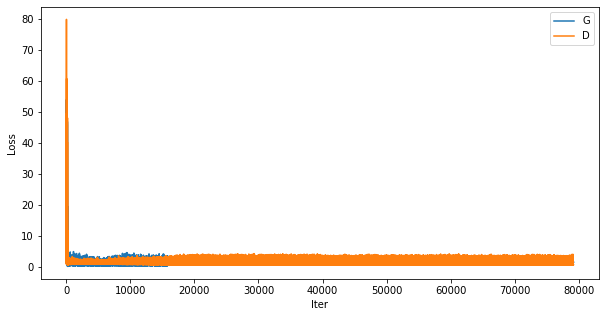

In [9]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

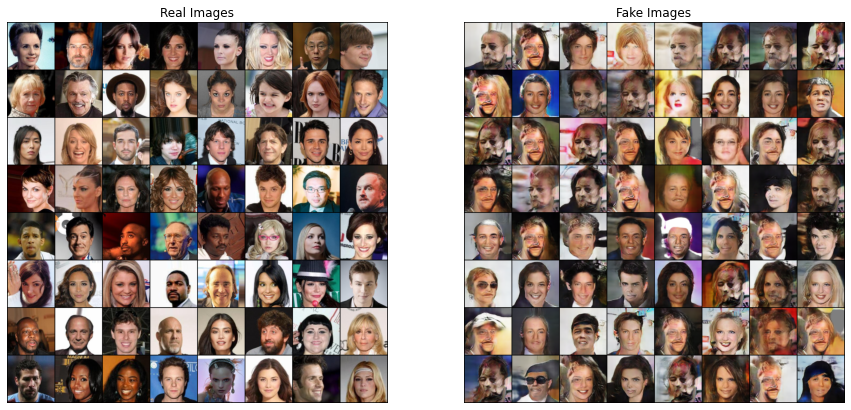

In [10]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()